# Introductory applied machine learning (INFR10069) 

# Lab 5: Clustering, PCA, and Evaluation

In this lab we consider unsupervised learning in the form of clustering methods and principal component analysis (PCA), as well as more thorough performance evaluation of classifiers.

All the datasets that you will need for this lab are located at the `./datasets` directory which is adjacent to this file.

In [1]:
# Import packages
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
%matplotlib inline

## Part 1: Clustering the landsat dataset

We first consider clustering of the Landsat data. For information about the Landsat data you can read [this description](http://www.inf.ed.ac.uk/teaching/courses/dme/html/landsat.html). Since there are 6 classes in the data, it would be interesting to try clustering with k=6 centres...

### ========== Question 1.1 ==========
1. With pandas, read the csv dataset located at './datasets/landsat.csv'
1. Split the data into the features `X` (pandas dataframe), and the labels `y` (easier to make it a numpy array)
1. Give it a once over
    * Get a feel for the size
    * Check it looks ok
    * Understand what the features are
    * Plot the class distribution

(4435, 36)
          pixel1_1     pixel1_2     pixel1_3     pixel1_4     pixel2_1  \
count  4435.000000  4435.000000  4435.000000  4435.000000  4435.000000   
mean     69.473957    83.855242    99.322886    82.555581    69.208794   
std      13.649635    22.725079    16.672166    18.695450    13.552423   
min      40.000000    27.000000    56.000000    33.000000    40.000000   
25%      60.000000    71.000000    85.000000    70.000000    60.000000   
50%      68.000000    87.000000   101.000000    83.000000    68.000000   
75%      80.000000   103.000000   113.000000    92.000000    80.000000   
max     104.000000   137.000000   140.000000   154.000000   102.000000   

          pixel2_2     pixel2_3     pixel2_4     pixel3_1     pixel3_2  \
count  4435.000000  4435.000000  4435.000000  4435.000000  4435.000000   
mean     83.499436    99.174521    82.480496    68.963472    83.131003   
std      22.811809    16.627583    18.714272    13.497858    22.813312   
min      27.000000    50.0

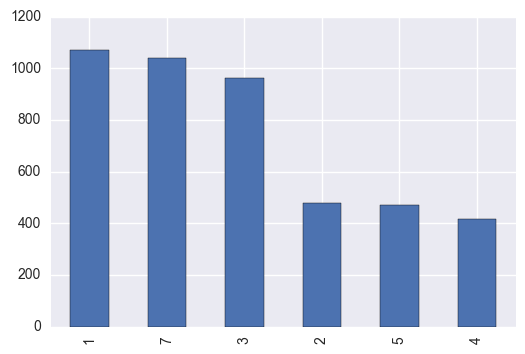

In [2]:
landsat = pd.read_csv('datasets/landsat.csv')
landsat_X = landsat.drop('class', axis = 1)
landsat_y = landsat['class']

print(landsat_X.shape)
print(landsat_X.describe())

fig, ax = plt.subplots()
landsat_y.value_counts().plot(kind = 'bar', ax = ax)
plt.show()

### ========== Question 1.2 ==========

*Tip - don't get stuck on this, move on after 10 mins or so (it's not critical)*

Plot a few datapoints. You'll need to understand and reshape the datapoints to do this. *Hint: try reading the [detailed description](http://www.inf.ed.ac.uk/teaching/courses/dme/html/satdoc.txt), it'll take you 2 minutes...`plt.imshow()` or `sns.heatmap()` (with an `ax.invert_yaxis()`) may also be handy ;)*

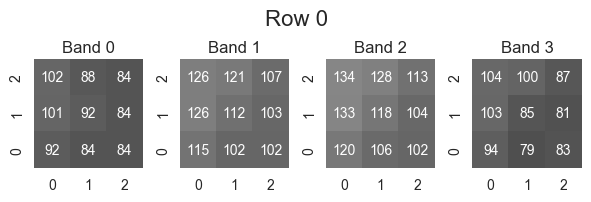

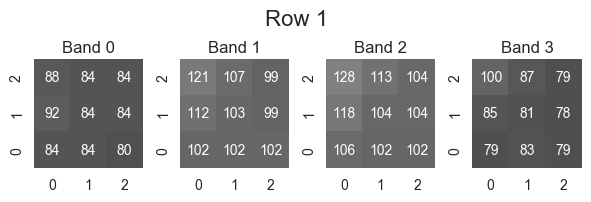

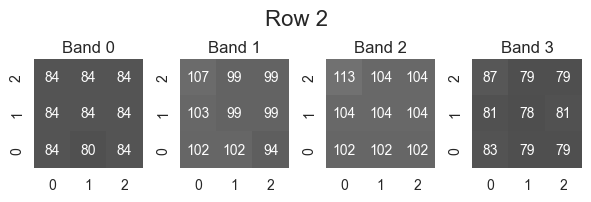

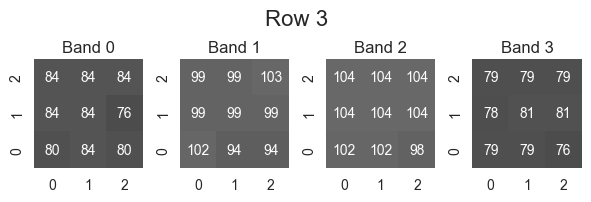

In [3]:
def get_images(row, bands=None):    
    # Get each of the 4 3x3 images contained in the row
    # Pixels are labeled 1 to 9 from topleft to bottom right
    # They are measured at 4 spectral bands
    #
    # row - a numpy array
    if bands is None:
        img = [[]] * 4
        for ii in range(4):
            img[ii] = row[[4*p + ii for p in range(9)]].reshape((3,3)).astype(int)
    elif isinstance(bands, int):
        img = row[[4*p + bands for p in range(9)]].reshape((3,3)).astype(int)
    elif isinstance(bands, list):
        img = [[]] * len(bands)
        for ii, band in enumerate(bands):
            img[ii] = row[[4*p + band for p in range(9)]].reshape((3,3)).astype(int)
    return img
        
for ii in range(4):
    fig, ax = plt.subplots(1,4)
    plt.suptitle('Row {}'.format(ii), fontsize=16)
    for jj, img in enumerate(get_images(landsat.iloc[ii,:])):
        ax[jj] = sns.heatmap(img, annot=True, fmt="d", ax=ax[jj], vmin=0, vmax=255, 
                    cbar=False, square=True, cmap=plt.cm.gray)
        ax[jj].invert_yaxis()
        ax[jj].set_title('Band {}'.format(jj))
    plt.tight_layout()
    plt.subplots_adjust(top=1.4)

### ========== Question 1.3 ==========

Read [this demonstration of k-means clustering assumptions](http://scikit-learn.org/0.17/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) from the sklearn documentation. Get a feel for how to create and fit a k-means object and what the different arguments do.

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 6 clusters, and one other parameter that ensures you can reproduce your results (other arguments kept as default). Call the object `kmeans`. Use the `fit()` method to fit to the training data (`X` - the features of `landsat` created above)

**Be careful to fit `X` - only the features - not the class labels!**

In [4]:
km = KMeans(n_clusters = 6, random_state = 0)
km.fit(landsat_X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)

### ========== Question 1.4 ==========

So, how well did that work? Are the classes well separated and form 6 nice clusters? The sklearn documentation gives a great introduction to k-means [here](http://scikit-learn.org/stable/modules/clustering.html#k-means). It describes what the algorithm is trying to minimise - the squared difference between datapoints and their closest cluster centre - a.k.a. the **inertia**. Lower inertia implies a better fit.

Since we have the true class labels in this case, we can use another metric: the [adjusted rand index](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). Understand what it is and roughly how it is calculated (try the [mathematical formulation on sklearn](http://scikit-learn.org/stable/modules/clustering.html#mathematical-formulation) or [on wikipedia](https://en.wikipedia.org/wiki/Rand_index)).

Print the `inertia` and the `adjusted_rand_score` of the kmeans object. The inertia is contained within the `kmeans` object you just fitted as a property. You need to use `y` and the cluster labels (another property of the `kmeans` object you just made), and are welcome to use the sklearn metrics function [adjusted_rand_score](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.adjusted_rand_score.html).

In [5]:
print(km.inertia_)
print(adjusted_rand_score(landsat_y, km.labels_))

11321538.9539
0.5340885876787153


### ========== Question 1.5 ==========

Let's have a look at the counts of the labels within each cluster. If the clustering has worked well, and the labels are inticative of genuine difference in the data, we should expect each cluster to have one dominant label.

Use `sns.countplot` on `kmeans.labels_` with a hue of `y` to get a plot that counts the number of instances within each cluster, and breaks them down by the class labels.

Below the plot, comment on:
1. How successful the clustering has been at separating data with different labels
1. Focussing on clusters, which are the best?
1. Focussing on labels, which are well identified by the clustering?
1. Which labels are the hardest to determine by the data point cluster assignment?

**Extension**: create a vector `y_labels` from `y` which has the names for the classes for a more interpretable plot with respect to the data

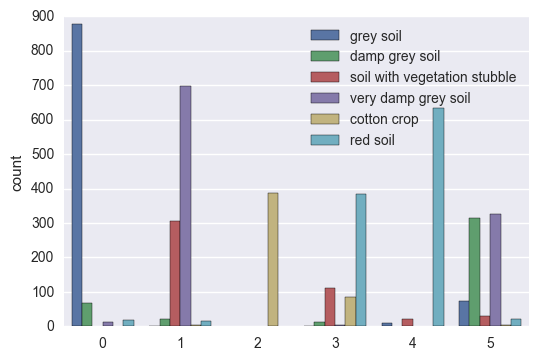

In [6]:
labels = ['red soil','cotton crop','grey soil', 'damp grey soil', 'soil with vegetation stubble',
          'mixture class (all types present)', 'very damp grey soil']

landsat_y_labels = [labels[c - 1] for c in landsat_y]

sns.countplot(km.labels_, hue = landsat_y_labels)
plt.show()

1. In general, the clustering has done a reasonable job of separating the data. Grey soil, cotton crop, and red soil are completely dominant in one cluster. However, two of the remaining three are split between one label and a significant amount in two or three others, and red soil is probably not the correct label for cluster 3 since it's clearly correct for 4. The final cluster is almost evenly distributed between two labels.

2. Grey soil and red soil are highly dominant within clusters 0 and 4, but each cluster also contains some other labels. Only cluster 2 is solely one label.

3. Grey soil and cotton crop are mostly separated out into a single cluster. However, both cotton crop and vegetation stubble appear to be confused with red soil (in cluster 3), while very damp grey soil splits clusters 1 and 5 with vegetation stubble and damp grey soil respectively, suggesting that it is different to distinguish between them.

4. As above, damp/very damp grey soil are hard to distinguish from each other, with the latter also being difficult to tell from vegetation stublle.

## Part 2: Dimensionality reduction

The landsat data is 36 dimensional, so we cannot visualise it, with respect to class, on a nice two dimensional plot. Additionally, as dimensionality increases, euclidean distance [becomes less meaningful](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Distance_functions)...

Perhaps if we found a lower dimensional subspace the data lies upon, we could more easily distinguish the datapoints...

### ========== Question 2.1 ==========

Have a look at the [PCA example](http://scikit-learn.org/0.17/auto_examples/decomposition/plot_pca_iris.html) in the sklearn documentation. For more information about PCA and decomposition in general check out the sklearn [user guide on decomposition](http://scikit-learn.org/stable/modules/decomposition.html#pca).

We are going to project the data down to 2 dimensions and visualise it using PCA. 

1. Create `pca`, an instance of an [sklearn PCA object](http://scikit-learn.org/0.17/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), setting n_components to 2. 
1. Create `X_2d` by using the pca method `fit_transform()` and supplying the features `X` to fit and transform to 2d.

In [7]:
pca = PCA(n_components = 2)
landsat_X_2d = pca.fit_transform(landsat_X)

### ========== Question 2.2 ==========

Let's visualise the data! Use a scatterplot and colour the datapoints by their class. You'll find [this example](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html) very helpful to stea-I mean, adapt. 

Below the plot, comment on whether the data looks more or less seperable now. Do the data look like they will be confused by a k-means clustering in the same way now?

**Extension**: Unless the data is somehow magically perfectly seperable, you may want to try and describe the space a little better than a scatterplot (bacause points are plotted on top of one another). Try and make a plot that clarifies the location of the classes. We're actually interested in where the **density** is.

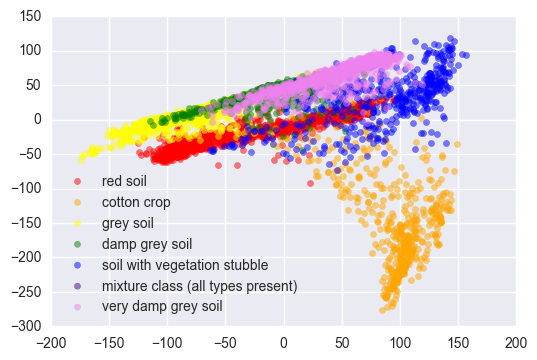

In [8]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
for i, label in enumerate(labels):
    plt.scatter(landsat_X_2d[[i for i, c in enumerate(landsat_y == i + 1) if c == True], 0],
                landsat_X_2d[[i for i, c in enumerate(landsat_y == i + 1) if c == True], 1], color = colors[i], label = label,
                alpha = 0.5)

plt.legend(loc = 'lower left')
plt.show()

It looks like k-means clustering will still be able to separate some of the classes, particularly cotton crop, vegetation stubble, and grey soil as they have the least overlap with everything else. However, damp and very damp grey soil are almost on top of each other, and red soil mixes with several other classes, so it's hard to say whether it will be able to pull these classes out.

### ========== Question 2.3 ==========

Let's find out whether it's easier to model the transformed data. Fit k-means to the transformed data and report the inertia and the adjusted rand index. Below, comment on whether it is better or worse.

In [9]:
km.fit(landsat_X_2d)
print(km.inertia_)
print(adjusted_rand_score(landsat_y, km.labels_))

4807402.39074
0.32600111734364634


The rand score is significantly lower than before, indicating that k-means classification performs worse on the transformed data.

### ========== Question 2.4 ==========

The blobs in the 2 dimensional plot do look quite gaussian...try another classifier on the 2d data and see if it can perform better. What about using 3 principal component? 

Maybe there are subclasses within each class? Maybe increasing the number of clusters will increase your `adjusted_rand_score`.

Use the adjusted rand score for fair comparison. Why do you think it works better or worse? Discuss with your colleagues and lab tutors why you think you got better/worse/the same results.

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

for nc in range(1, len(landsat_X.columns) + 1):
    pca = PCA(n_components = nc)
    landsat_X_pca = pca.fit_transform(landsat_X)
    km.fit(landsat_X_pca)
    print('KM, {} component(s): inertia = {}, adjusted rand score = {}'.format(nc, km.inertia_,
                                                                               adjusted_rand_score(landsat_y, km.labels_)))
for ncl in range(1, 37):
    km = KMeans(n_clusters = ncl)
    for nco in range(1, len(landsat_X.columns) + 1):
        pca = PCA(n_components = nco)
        landsat_X_pca = pca.fit_transform(landsat_X)
        km.fit(landsat_X_pca)
        print('KM, {} cluster(s), {} component(s): inertia = {}, adjusted rand score = {}'.format(ncl, nco, km.inertia_,
                                                                                                  adjusted_rand_score(landsat_y,
                                                                                                                      km.labels_)))
        
for nc in range (1, len(landsat_X.columns) + 1):
    pca = PCA(n_components = nc)
    landsat_X_pca = pca.fit_transform(landsat_X)
    gnb = GaussianNB()
    gnb.fit(landsat_X_pca, landsat_y)
    print('GNB, {} component(s): score = {}, adjusted rand score = {}'.format(nc, gnb.score(landsat_X_pca, landsat_y),
                                                                              adjusted_rand_score(landsat_y,
                                                                                                  gnb.predict(landsat_X_pca))))

rfc = RandomForestClassifier(n_estimators = 500, random_state = 0, oob_score = True)
rfc.fit(landsat_X, landsat_y)
print("RFC, score = {}, adjusted rand score = {}".format(rfc.oob_score_, adjusted_rand_score(landsat_y, rfc.predict(landsat_X))))

KM, 1 component(s): inertia = 24794.18873788442, adjusted rand score = 0.06283339715447066
KM, 2 component(s): inertia = 562313.5257326707, adjusted rand score = 0.19732709899572287
KM, 3 component(s): inertia = 811153.9262511767, adjusted rand score = 0.20894917966492885
KM, 4 component(s): inertia = 1731117.9220321928, adjusted rand score = 0.21142198996537803
KM, 5 component(s): inertia = 2209587.7638904364, adjusted rand score = 0.2276580109750793
KM, 6 component(s): inertia = 2988501.776290008, adjusted rand score = 0.2283554140074883
KM, 7 component(s): inertia = 3441121.1981795426, adjusted rand score = 0.23809352506747625
KM, 8 component(s): inertia = 3696755.7393460395, adjusted rand score = 0.23618115452842758
KM, 9 component(s): inertia = 3862317.705426628, adjusted rand score = 0.24806014657073114
KM, 10 component(s): inertia = 4056647.733160463, adjusted rand score = 0.23430359776551318
KM, 11 component(s): inertia = 4152749.298027273, adjusted rand score = 0.2461057080981

# Credits

Lab prepared by Lawrence Murray and Chris Williams, November 2008; revised Athina Spiliopoulou Nov 2009; revised Sean Moran Nov 2011; revised Boris Mitrovic Oct 2013; revised and converted to ipython notebook by James Owers and Agamemnon Krasoulis Oct 2016